# Телеграм  чат-бот

In [8]:
#Неоходибмые библиотеки


pip install pyTelegramBotAPI
pip install mysql-connector-python
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib


SyntaxError: invalid syntax (<ipython-input-8-317b0e69d3d2>, line 4)

Схема БД

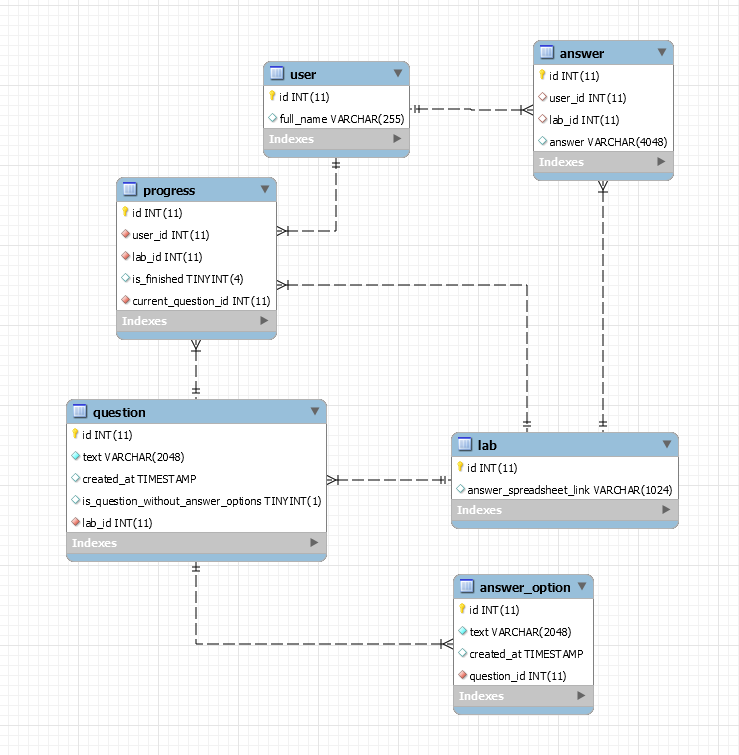

user - содержит ID и ФИО пользователей

lab - содержит ID лабораторной работы и ID таблицы с ответами 

question - cодержит список вопросов

answer_option - содержит варианты ответов

answer - содержит ответы пользователя

progress - содержит информации о текущей незавершенной лабораторной работы


In [6]:
# Подключение к БД
from mysql.connector import connect, Error


def init_database_connection():
    return connect(
        host="localhost",
        user="root",
        password="1234",
        database="lab"
    )


ModuleNotFoundError: No module named 'mysql'

In [ ]:
# Инициализация Google API

import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials

SCOPES = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]


def init_google_drive_api():
    credentials = None
    if os.path.exists('token.json'):
        credentials = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            credentials = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.json', 'w') as token:
            token.write(credentials.to_json())

    return build('drive', 'v3', credentials=credentials)


def init_google_spreadsheet_api():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            credentials = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)

    return build('sheets', 'v4', credentials=credentials)


Методы для работы с данными из БД

In [ ]:
# Репозитории

import db

database = db.init_database_connection()


def create_question(lab_id, text, is_question_without_answer_options):
    sql = "INSERT INTO question (lab_id, text, is_question_without_answer_options) VALUES (%s, %s, %s)"
    value = [lab_id, text, is_question_without_answer_options]
    cursor = database.cursor()
    cursor.execute(sql, value)
    database.commit()
    return cursor.lastrowid


def get_question(question_id):
    sql = "SELECT text, is_question_without_answer_options FROM question WHERE id = (%s) LIMIT 1"
    value = [question_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    question = cursor.fetchall()[0]
    answer_options = None
    if question[1]:
        sql = "SELECT text FROM answer_option WHERE question_id = (%s)"
        value = [question_id]
        cursor = database.cursor()
        cursor.execute(sql, value)
        answer_options = cursor.fetchall()
    return [question, answer_options]





In [ ]:
# Репозитории

import db

database = db.init_database_connection()


def get_current_question(user_id):
    sql = "SELECT current_question_id, lab_id FROM progress WHERE is_finished = false AND user_id = (%s) LIMIT 1"
    value = [user_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    return result[0]


def set_next_question(user_id, lab_id, current_question_id):
    sql = "SELECT id FROM question WHERE lab_id = (%s) ORDER BY created_at ASC"
    value = [lab_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    questions = cursor.fetchall()
    current_question_position = -1
    for i in range(0, len(questions)):
        if questions[i][0] == current_question_id:
            current_question_position = i
    if current_question_position + 1 == len(questions):
        sql = "UPDATE progress SET is_finished = true WHERE lab_id = (%s) AND user_id = (%s)"
        value = [lab_id, user_id]
        cursor = database.cursor()
        cursor.execute(sql, value)
        database.commit()
        return True
    else:
        sql = "UPDATE progress SET current_question_id = %s WHERE lab_id = (%s) AND user_id = (%s)"
        values = [questions[current_question_position + 1][0], lab_id, user_id]
        cursor = database.cursor()
        cursor.execute(sql, values)
        database.commit()
        return False


In [ ]:
# Репозитории

import db

database = db.init_database_connection()


def get_answer_spreadsheet_link(lab_id):
    sql = "SELECT answer_spreadsheet_link FROM lab WHERE id = (%s) LIMIT 1"
    value = [lab_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    return result[0][0]


def is_lab_exist(lab_id):
    sql = "SELECT * FROM lab WHERE id = (%s) LIMIT 1"
    value = [lab_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    return len(result) != 0


def is_user_has_unfinished_labs(user_id):
    sql = "SELECT * FROM progress WHERE user_id = (%s) AND is_finished = 0"
    value = [user_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    return len(result) != 0


def is_user_finished_lab(user_id, lab_id):
    sql = "SELECT * FROM progress WHERE user_id = (%s) AND is_finished = 1 AND lab_id = (%s)"
    value = [user_id, lab_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    return len(result) != 0


def create_new_lab_for_user(user_id, lab_id):
    sql = "SELECT id, text, is_question_without_answer_options FROM question WHERE lab_id = (%s) ORDER BY created_at ASC LIMIT 1"
    value = [lab_id]
    cursor = database.cursor()
    cursor.execute(sql, value)
    result = cursor.fetchall()
    current_question_id = result[0][0]
    sql = "INSERT INTO progress (user_id, lab_id, current_question_id) VALUES (%s, %s, %s)"
    values = [user_id, lab_id, current_question_id]
    cursor = database.cursor()
    cursor.execute(sql, values)
    database.commit()


def create_lab():
    sql = "INSERT INTO lab (answer_spreadsheet_link) VALUES (null)"
    cursor = database.cursor()
    cursor.execute(sql)
    database.commit()
    return cursor.lastrowid


def set_answer_spreadsheet_link(lab_id, answer_spreadsheet_link):
    sql = "UPDATE lab SET answer_spreadsheet_link = (%s) WHERE id = (%s)"
    values = [answer_spreadsheet_link, lab_id]
    cursor = database.cursor()
    cursor.execute(sql, values)
    database.commit()


In [ ]:
# Репозитории

import db

database = db.init_database_connection()


def create_answer(user_id, lab_id, answer):
    sql = "INSERT INTO answer (user_id, lab_id, answer) VALUES (%s, %s, %s)"
    values = [user_id, lab_id, answer]
    cursor = database.cursor()
    cursor.execute(sql, values)
    database.commit()


def get_answers(user_id, lab_id):
    sql = "SELECT answer FROM answer WHERE user_id = (%s) AND lab_id = (%s)"
    values = [user_id, lab_id]
    cursor = database.cursor()
    cursor.execute(sql, values)
    return cursor.fetchall()


In [ ]:
# Репозитории 

import db

db = db.init_database_connection()


def create_answer(question_id, answer):
    sql = "INSERT INTO answer_option (text, question_id) VALUES (%s, %s)"
    value = [answer, question_id]
    cursor = db.cursor()
    cursor.execute(sql, value)
    db.commit()


In [ ]:
Основная логика приложения

У пользователя есть два метода:
    1. Создать опрос, указав ссылку на таблицу с вопросами и ссылку на папку Google disc
    2. Пройти опрос, указав ID лабораторной работы
    
При первом запуске чат-бота пользователь должен укзаать ФИО
    

In [ ]:
#!/usr/bin/python
from __future__ import print_function

import telebot
import db
import user_repository
import lab_repository
import question_repository
import answer_option_repository
import progress_repository
import answer_repository
import api
import util
from telebot import types

bot = telebot.TeleBot("TOKEN")
spreadsheetApi = api.init_google_spreadsheet_api()
driveApi = api.init_google_drive_api()
db = db.init_database_connection()


def pass_lab(message):
    if lab_repository.is_user_has_unfinished_labs(message.from_user.id):
        bot.send_message(message.chat.id, 'Чтобу начать новую лаборотную работу сначало завершите текущию')
    else:
        markup = types.ReplyKeyboardRemove(selective=False)
        bot.send_message(message.chat.id, "ID лабороторной работы", reply_markup=markup)
        bot.register_next_step_handler(message, process_pass_lab_step)


def process_pass_lab_step(message):
    if not lab_repository.is_lab_exist(message.text):
        bot.send_message(message.chat.id, "Лабороторная работа не существует")
        bot.register_next_step_handler(message, pass_lab)
        return
    if lab_repository.is_user_finished_lab(message.from_user.id, message.text):
        bot.send_message(message.chat.id, "Вы уже проходили эту работу")
        bot.register_next_step_handler(message, pass_lab)
    else:
        lab_repository.create_new_lab_for_user(message.from_user.id, message.text)
        current_question_id = progress_repository.get_current_question(message.from_user.id)[0]
        question = question_repository.get_question(current_question_id)
        if question[0][1] == 1:
            markup = types.ReplyKeyboardMarkup()
            for i in range(0, len(question[1])):
                markup.add(types.KeyboardButton(question[1][i][0]))
            bot.send_message(message.chat.id, 'Выберите ответ', reply_markup=markup)
        else:
            bot.send_message(message.chat.id, question[0][0])


def answer(message):
    if lab_repository.is_user_has_unfinished_labs(message.from_user.id):
        current_question = progress_repository.get_current_question(message.from_user.id)
        answer_repository.create_answer(message.from_user.id, current_question[1], message.text)

        if progress_repository.set_next_question(message.from_user.id, current_question[1], current_question[0]):
            markup = types.ReplyKeyboardMarkup()
            markup.add(types.KeyboardButton("Создать лабораторную работу"))
            markup.add(types.KeyboardButton("Пройти лабораторную работу"))
            bot.send_message(message.chat.id, 'Лабораторная работа завершена', reply_markup=markup)

            spreadsheet_link = lab_repository.get_answer_spreadsheet_link(current_question[1])
            answers = answer_repository.get_answers(message.from_user.id, current_question[1])
            full_name = user_repository.get_user_full_name(message.from_user.id)
            print(spreadsheet_link)
            print(answers)

            sheet_info = spreadsheetApi.spreadsheets().get(spreadsheetId=spreadsheet_link).execute()["sheets"][0][
                "properties"]
            values = [
                [
                ],
            ]
            values[0].append(full_name)
            for i in range(0, len(answers)):
                values[0].append(answers[i][0])
            body = {
                'values': values
            }
            print(values)
            try:
                result = spreadsheetApi.spreadsheets().values().append(
                    spreadsheetId=spreadsheet_link, range=sheet_info["title"],
                    valueInputOption="RAW", body=body).execute()
            except Exception as e:
                print(e)
        else:
            current_question_id = progress_repository.get_current_question(message.from_user.id)[0]
            question = question_repository.get_question(current_question_id)
            if question[0][1] == 1:
                markup = types.ReplyKeyboardMarkup()
                for i in range(0, len(question[1])):
                    markup.add(types.KeyboardButton(question[1][i][0]))
                bot.send_message(message.chat.id, 'Выберите ответ', reply_markup=markup)
            else:
                markup = types.ReplyKeyboardRemove(selective=False)
                bot.send_message(message.chat.id, question[0][0], reply_markup=markup)


class Lab:
    def __init__(self, lab_id):
        self.lab_id = lab_id


labs = {}


def create_lab(message):
    markup = types.ReplyKeyboardRemove(selective=False)
    bot.send_message(message.chat.id,
                     'Ссылка на Google таблица с вопросами. Таблица должна быть доступна для всех у кого есть ссылка. '
                     'Ссылка вида: '
                     'https://docs.google.com/spreadsheets/d/1QmmRlZcEP_9ul_0iEXkivNYeGDjeZDXbPTC5G_Kjcf8/edit?usp'
                     '=sharing',
                     reply_markup=markup)
    bot.register_next_step_handler(message, process_question_spreadsheet_link_step)


def process_question_spreadsheet_link_step(message):
    try:
        if not util.is_url(message.text):
            new_message = bot.send_message(message.chat.id, 'Некорректная ссылка')
            bot.register_next_step_handler(new_message, create_lab(new_message))
        else:
            chat_id = message.chat.id
            lab_id = lab_repository.create_lab()
            lab = Lab(lab_id)
            labs[chat_id] = lab
            spreadsheet_id = util.extract_google_spreadsheet_id(message.text)
            sheet_info = spreadsheetApi.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()["sheets"][0][
                "properties"]
            sheet = spreadsheetApi.spreadsheets().values().get(spreadsheetId=spreadsheet_id,
                                                               range=sheet_info["title"]).execute()["values"]
            for i in range(len(sheet)):
                question_id = question_repository.create_question(lab_id, sheet[i][0], len(sheet[i]) != 1)
                for j in range(1, len(sheet[i])):
                    answer_option_repository.create_answer(question_id, sheet[i][j])

            new_message = bot.send_message(message.chat.id,
                                           'Ссылка на Google Disk папку для ответов. Папка должна быть доступна для '
                                           'всех у кого есть ссылка. Ссылка вида: '
                                           'https://drive.google.com/drive/folders/1BqyY_KkwdK2lcxxGKinq5bKYYbJ75klv'
                                           '?usp=sharing')
            bot.register_next_step_handler(new_message, process_answer_spreadsheet_link_step)
    except Exception as e:
        bot.register_next_step_handler(message, create_lab(message))


def process_answer_spreadsheet_link_step(message):
    try:
        if not util.is_url(message.text):
            new_message = bot.send_message(message.chat.id, 'Некорректная ссылка')
            bot.register_next_step_handler(new_message, process_answer_spreadsheet_link_step)
        else:
            chat_id = message.chat.id
            lab = labs[chat_id]
            spreadsheet = {
                'properties': {
                    'title': "Ответы " + str(lab.lab_id)
                }
            }
            new_spreadsheet_id = \
                spreadsheetApi.spreadsheets().create(body=spreadsheet, fields='spreadsheetId').execute()[
                    "spreadsheetId"]

            lab_repository.set_answer_spreadsheet_link(lab.lab_id, new_spreadsheet_id)

            permission = {
                'type': 'anyone',
                'role': 'writer',
            }
            driveApi.permissions().create(fileId=new_spreadsheet_id, body=permission, fields='id').execute()

            folder_id = util.extract_google_disc_folder(message.text)
            file = driveApi.files().get(fileId=new_spreadsheet_id, fields='parents').execute()
            driveApi.files().update(fileId=new_spreadsheet_id, addParents=folder_id,
                                    removeParents=",".join(file.get('parents')), fields='id, parents').execute()
            markup = types.ReplyKeyboardMarkup()
            markup.add(types.KeyboardButton("Создать лабораторную работу"))
            markup.add(types.KeyboardButton("Пройти лабораторную работу"))
            bot.send_message(message.chat.id, "Лабораторная работа создана, ID: " + str(lab.lab_id),
                             reply_markup=markup)
    except Exception as e:
        bot.register_next_step_handler(message, create_lab(message))


@bot.message_handler(commands=['start'])
def start_message(message):
    if not user_repository.is_user_exist(message.from_user.id):
        bot.send_message(message.chat.id, "ФИО")
        bot.register_next_step_handler(message, process_register_link_step)
    markup = types.ReplyKeyboardMarkup()
    markup.add(types.KeyboardButton("Создать лабораторную работу"))
    markup.add(types.KeyboardButton("Пройти лабораторную работу"))
    bot.send_message(message.chat.id, 'Выберите действие', reply_markup=markup)


def process_register_link_step(message):
    try:
        if not user_repository.is_user_exist(message.from_user.id):
            user_repository.create_user(message.from_user.id, message.text)
        markup = types.ReplyKeyboardMarkup()
        markup.add(types.KeyboardButton("Создать лабораторную работу"))
        markup.add(types.KeyboardButton("Пройти лабораторную работу"))
        bot.send_message(message.chat.id, 'Выберите действие', reply_markup=markup)
    except Exception as error:
        bot.register_next_step_handler(message, start_message)


@bot.message_handler(func=lambda m: True)
def new_message(message):
    if message.text == 'Создать лабораторную работу':
        create_lab(message)
        return
    if message.text == 'Пройти лабораторную работу':
        pass_lab(message)
        return
    answer(message)


bot.enable_save_next_step_handlers(delay=2)
bot.load_next_step_handlers()
bot.polling()


In [ ]:
Вспомогтальный код, для проверки ссылок и извлечения из них ID таблицы и папки

In [ ]:
import re


def is_url(url):
    regex = re.compile(
        r'^(?:http|ftp)s?://'  # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'
        r'localhost|'  # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'  # ...or ip
        r'(?::\d+)?'  # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
    return re.match(regex, url) is not None


def extract_google_spreadsheet_id(url):
    url = url.replace('https://docs.google.com/spreadsheets/d/', '')
    url = url.replace('/edit?usp=sharing', '')
    return url


def extract_google_disc_folder(url):
    url = url.replace('https://drive.google.com/drive/folders/', '')
    url = url.replace('?usp=sharing', '')
    return url
